In [1]:
%matplotlib inline
import quantstats as qs

# extend pandas functionality with metrics, etc.
qs.extend_pandas()

In [2]:
# fetch the daily returns for a stock
stock = qs.utils.download_returns('RELIANCE.NS')

YF deprecation warning: set proxy via new config function: yf.set_config(proxy=proxy)


In [3]:
stock.dropna(inplace=True)

In [4]:
stock

Date
1996-01-02   -0.007777
1996-01-03    0.007592
1996-01-04   -0.009237
1996-01-05   -0.006870
1996-01-08   -0.040020
                ...   
2025-04-29    0.022574
2025-04-30    0.003787
2025-05-02    0.010534
2025-05-05    0.008100
2025-05-06   -0.007266
Name: Close, Length: 7364, dtype: float64

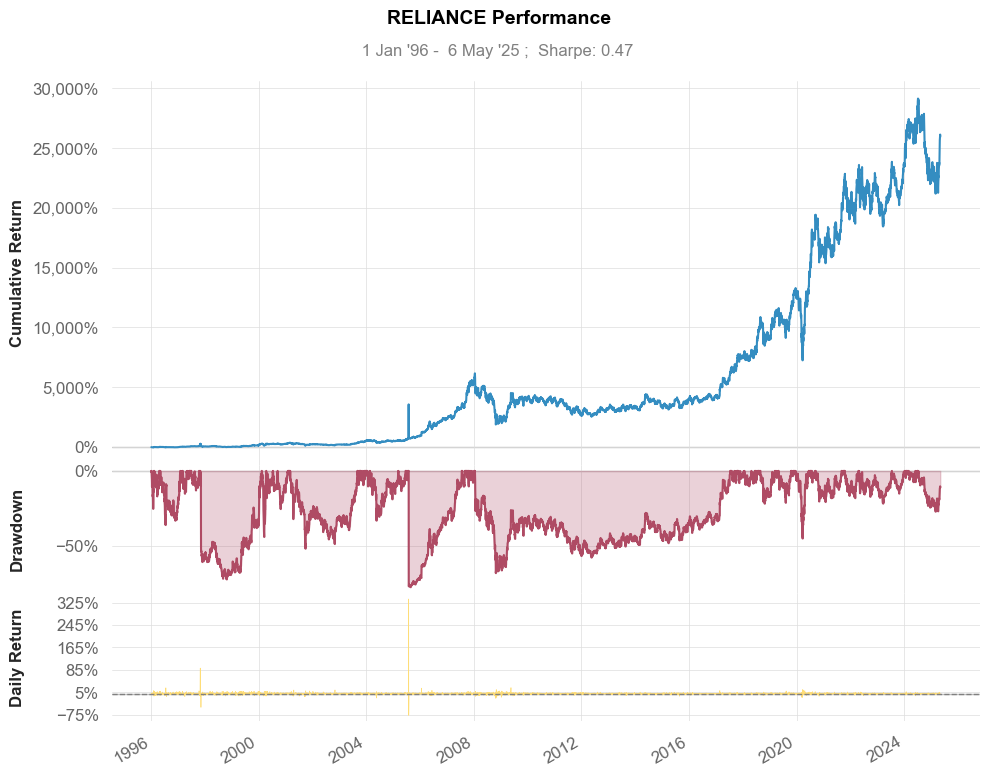

In [5]:
qs.plots.snapshot(stock, title='RELIANCE Performance', show=True)

In [2]:
import quantstats._plotting.wrappers as _qs_wrappers
from functools import wraps

if not getattr(_qs_wrappers.yearly_returns, "_patched_freq", False):
    _orig_yearly = _qs_wrappers.yearly_returns

    @wraps(_orig_yearly)
    def _yearly_fixed(returns, *args, **kwargs):
        # Internally, wrappers.yearly_returns does `returns.resample("YE")`
        # We patch that on the fly by replacing YE -> A
        # Provide a local lambda so we don't alter global state
        _returns_fixed = returns.copy()
        _returns_fixed.__dict__["resample"] = lambda freq, *a, **k: \
            returns.resample("A" if freq.upper() == "YE" else freq, *a, **k)
        return _orig_yearly(_returns_fixed, *args, **kwargs)

    _yearly_fixed._patched_freq = True
    _qs_wrappers.yearly_returns = _yearly_fixed


In [1]:
import warnings
warnings.filterwarnings(
    "ignore",
    message="A value is trying to be set on a copy of a DataFrame or Series",
    category=FutureWarning,
    module=r"quantstats\._plotting\.core"
)


In [3]:
import pandas as pd
from pandas.core.resample import Resampler

# --- 1. one‑time axis‑kwarg patch ----------------------------------------
if not getattr(Resampler, "_qs_axis_patch", False):
    _orig_sum = Resampler.sum
    Resampler.sum = lambda self, *a, **k: _orig_sum(self, *a)  # ignore axis
    Resampler._qs_axis_patch = True
# -------------------------------------------------------------------------

import yfinance as yf, quantstats as qs

# 2. download data (MultiIndex by default)
data = yf.download("RELIANCE.NS", start="2018-01-01", progress=False)

# 3. pick Close/Adj Close robustly
lvl0 = data.columns.get_level_values(0)
close_col = "Adj Close" if "Adj Close" in lvl0 else "Close"
close = data.xs(close_col, level=0, axis=1).squeeze()

# 4. returns
returns = close.pct_change().dropna()

# 5. tear‑sheet
qs.reports.html(
    returns,
    title="RELIANCE.NS Tearsheet",
    output="reliance_tearsheet.html"
)
print("✅  reliance_tearsheet.html generated")


✅  reliance_tearsheet.html generated


In [5]:
import warnings, yfinance as yf, quantstats as qs, pandas as pd
from pandas.core.resample import Resampler

# ── 1. one‑time pandas‑2.2 axis‑kwarg patch (skip if already in your session) ──
if not getattr(Resampler, "_qs_axis_patch", False):
    _orig_sum = Resampler.sum
    Resampler.sum = lambda self, *a, **k: _orig_sum(self, *a)   # drop axis kwarg
    Resampler._qs_axis_patch = True
# ───────────────────────────────────────────────────────────────────────────────

# (Optional) keep QuantStats future‑warnings quiet
warnings.filterwarnings(
    "ignore",
    message="A value is trying to be set on a copy of a DataFrame or Series",
    category=FutureWarning,
    module=r"quantstats\._plotting\.core"
)

# ── 2. download prices ────────────────────────────────────────────────────────
tickers   = ["RELIANCE.NS", "^NSEI"]
start_dt  = "2018-01-01"

data = yf.download(tickers, start=start_dt, progress=False)

# Helper to grab Close/Adj Close even with MultiIndex
def get_close(df, ticker):
    lvl0 = df.columns.get_level_values(0)
    col0 = "Adj Close" if "Adj Close" in lvl0 else "Close"
    return df.xs(col0, level=0, axis=1)[ticker]

reliance_px = get_close(data, "RELIANCE.NS")
nsei_px     = get_close(data, "^NSEI")

# ── 3. convert to returns & align dates ───────────────────────────────────────
reliance_ret = reliance_px.pct_change().dropna()
nsei_ret     = nsei_px.pct_change().dropna()

# inner‑join so both series have identical index
reliance_ret, nsei_ret = reliance_ret.align(nsei_ret, join="inner")

# ── 4. QuantStats tear‑sheet with benchmark ───────────────────────────────────
qs.reports.html(
    returns     = reliance_ret,
    benchmark   = nsei_ret,
    title       = "RELIANCE.NS vs NIFTY 50 (NSEI)",
    output      = "reliance_vs_nsei_tearsheet.html"
)

print("✅  Saved reliance_vs_nsei_tearsheet.html")


C:\Users\Admin1\AppData\Local\Temp\ipykernel_78904\4044475966.py:36: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  nsei_ret     = nsei_px.pct_change().dropna()


✅  Saved reliance_vs_nsei_tearsheet.html
